In [45]:
# Import libraries
import xml.etree.ElementTree as ET #parse xml file
import pandas as pd 

## Approach:  Logic 1 + Logic 2
> **Step-1:** Parse train and test xml file and extract all the review text and aspect terms <br>
<br>
> **Step-2:** Create domain product aspect(train_aspect): Already given in training data<br>
<br>
> **Step-3:** Extracting aspect terms using syntactic dependencies of words in a sentence.(only for test data)<br>
- **What syntactical relations should be exploited?**<br>
- > I use Stanford CoreNLP tool.The following grammatical dependencies are used to extract and construct the aspect opinion phrases inside a short sentence.I just explain few of them. The Stanford typed dependencies manual explains very well the grammatical representations used below.<br>
<br> 
> In order to end-up with aspect phrases, first, basic patterns are extracted:<br> 
<br> **1. Adjectival modifier (amod):** This camera has great zoom* parsed to ==> amod(zoom, great)
<br> **2. "And" conjunct (conj and):** *This camera has great zoom and resolution* parsed to ==> conj and(zoom, resolution).
<br> **3. Direct object (dobj):** I love the quality parsed to ==> dobj(love, quality).
<br> **4. Noun compound modifier (compound):** *The battery life is not long* parsed to ==> compound(life, battery)*.
<br> **5. Nominal subject (nsubj):** *The screen is wide* parsed to ==> nsubj(wide, screen).<br> 
<br> 
Of course, these syntactical relations can be improved further on by looking up more combined patterns but I have a gut feeling there are more combined patterns out there.<br>

> **Step-4:** Link with Domain product aspects. 

> **Step-5:** Handel Aspect term with more than one token!

> **Step-6:** Pruning the extracted patterns
- As you can see in the above results, the pruning step is quite important, as the "battery", "life" are the most significant patterns to keep, the final ones. I wanted aspect phrases "battery life" from ("battery life", "battery", "life"). So I did redundant removal to the pruning step. This basically means eliminating the patterns which contain any other aspect. Like: ("battery life", "battery", "life") ==> "battery life"

> **Step-7:** Conveart to BIO format 
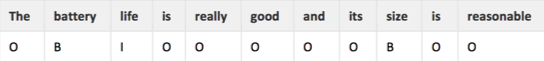

> **Step-8:** Evaluation

# Implementation 

## Step-1: Parse train and test xml file and extract all the review text and aspect terms

### Parse xml file 

In [2]:
def parse_xml(root):
    all_aspectTerms = [] #only aspect terms 
    all_text_And_Aspect = [] #review with aspect terms

    for sentences in root.findall('sentence'):
        text = sentences.find('text').text
        aspectTerms = sentences.find('aspectTerms')
        asp = []
        try: #Because, review text might not any aspect term
            for neighbor in aspectTerms.iter('aspectTerm'):
                asp1 = neighbor.attrib.get('term',"")
                all_aspectTerms.append(asp1.lower())
                asp.append(asp1)
            all_text_And_Aspect.append((text,asp))
        except:
            all_text_And_Aspect.append((text,asp))


    return (all_text_And_Aspect, list(set(all_aspectTerms)))  

### Traning data

In [3]:
train_tree = ET.parse('Laptops_Train_v2.xml')
train_root = train_tree.getroot()

training_all_text_And_Aspect, training_all_aspectTerms = parse_xml(train_root)

print (training_all_text_And_Aspect[0:5]) # format = (review text, [aspect trams,....])
print (training_all_aspectTerms[0:5])# only aspect terms

[('I charge it at night and skip taking the cord with me because of the good battery life.', ['cord', 'battery life']), ('I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.', []), ('The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from.', ['service center', '"sales" team', 'tech guy']), ('I investigated netbooks and saw the Toshiba NB305-N410BL.', []), ('The other day I had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.', [])]
['virus protection', 'commodity hardware', 'value', 'surf the web', 'screen brightness']


### Test data

In [4]:
test_tree = ET.parse('Laptops_Test_Gold.xml')
test_root = test_tree.getroot()

test_all_text_And_Aspect, test_all_aspectTerms = parse_xml(test_root)

print (test_all_text_And_Aspect[0:5])
print (test_all_aspectTerms[0:5])

[('Boot time is super fast, around anywhere from 35 seconds to 1 minute.', ['Boot time']), ('tech support would not fix the problem unless I bought your plan for $150 plus.', ['tech support']), ('but in resume this computer rocks!', []), ('Set up was easy.', ['Set up']), ('Did not enjoy the new Windows 8 and touchscreen functions.', ['Windows 8', 'touchscreen functions'])]
['value', '8g of ram', 'battery cycle count', 'backlit keys', 'bluetooth interface']


## Step-2: Create domain product aspect(train_aspect): Already given in training data

In [5]:
all_aspet_terms = training_all_aspectTerms.copy()

## Step-3: Extracting aspect terms using syntactic dependencies of words in a sentence.(only for test data)

In [6]:
#import stanford core nlp parser
from nltk.parse.corenlp import CoreNLPDependencyParser
dep_parser = CoreNLPDependencyParser(url='http://localhost:9000')

In [33]:
# This function use for syntactic dependencies finding and aspect extraction
def get_aspect(test_text):
    token = CoreNLPParser(url='http://localhost:9000')
    aspect_term = []
    parses = dep_parser.parse(token.tokenize(" ".join(test_text.split("."))))
    syntactic_rules = [[(governor, dep, dependent) for governor, dep, dependent in parse.triples()] \
                         for parse in parses][0]
    
    back_up = []
    for rule in syntactic_rules:
        if rule[1] == 'dobj':
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V" ) and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'nsubj':
            fl=0
            fl2 =0 
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V" or rule[2][1][0] == "N"):
                aspect_term.append(rule[0][0])
                fl=1
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V" or rule[0][1][0] == "N"):
                aspect_term.append(rule[2][0])
                fl2=1
            if rule[0][1][0] == "N" and fl == 0:
                aspect_term.append(rule[0][0])
            elif rule[2][1][0] == "N" and fl2 ==0:
                aspect_term.append(rule[2][0])
        elif rule[1] == 'csubj':
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'nsubjpass':
            fl=0
            fl2 =0 
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V" or rule[2][1][0] == "N"):
                aspect_term.append(rule[0][0])
                fl=1
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V" or rule[0][1][0] == "N"):
                aspect_term.append(rule[2][0])
                fl2=1
            if rule[0][1][0] == "N" and fl == 0:
                aspect_term.append(rule[0][0])
            elif rule[2][1][0] == "N" and fl2 ==0:
                aspect_term.append(rule[2][0])
        elif rule[1] == 'amod':
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'nmod':
            fl=0
            fl2 =0 
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V"):
                aspect_term.append(rule[0][0])
                fl=1
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V"):
                aspect_term.append(rule[2][0])
            if rule[0][1][0] == "N" and fl == 0:
                aspect_term.append(rule[0][0])
                fl2=1
            elif rule[2][1][0] == "N" and fl2 ==0:
                aspect_term.append(rule[2][0])
            back_up.append(rule)
        elif rule[1] == 'nmod:tmod':
            if (rule[0][1][0] == "N") and (rule[2][1][0] == "J" or rule[2][1][0] == "R" or rule[2][1][0] == "V"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "N") and (rule[0][1][0] == "J" or rule[0][1][0] == "R" or rule[0][1][0] == "V"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'conj':
            if (rule[0][1][0] == "N" or rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "N" or rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R"):
                aspect_term.append(rule[2][0])
            back_up.append(rule)
        elif rule[1] == 'xcomp':
            if (rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'ccomp':
            if (rule[0][1][0] == "V") and (rule[2][1][0] == "J" or rule[2][1][0] == "R"):
                aspect_term.append(rule[0][0])
            elif (rule[2][1][0] == "V") and (rule[0][1][0] == "J" or rule[0][1][0] == "R"):
                aspect_term.append(rule[2][0])
        elif rule[1] == 'compound':
            back_up.append(rule)
        elif rule[1] == 'dep':
            if (rule[2][1][0] == "V" or rule[2][1][0] == "N"):
                aspect_term.append(rule[0][0])
            back_up.append(rule)
        elif rule[1] == 'neg':
            if (rule[2][1][0] == "N"):
                aspect_term.append(rule[2][0])
            elif (rule[0][1][0] == "N"):
                aspect_term.append(rule[0][0])
        
        for i in range(3):
            for r in back_up:
                if (r[0][0] in aspect_term) and (r[2][1][0] == "N" or r[2][1][0] == "V"):
                    aspect_term.append(r[2][0])
                elif (r[2][0] in aspect_term) and (r[0][1][0] == "N" or r[0][1][0] == "V"):
                    aspect_term.append(r[0][0])
    return (list(set(aspect_term)),syntactic_rules)

## Step-4: Filter with Domain product aspects. 

In [8]:
def filter_asp(aspect, all_aspet_terms):
    new_aspect = []
    for asp in aspect:
        for train_aspect in all_aspet_terms:
            if asp.lower() == train_aspect.lower():
                new_aspect.append(asp)
    return list(set(new_aspect))

## Step-5: Handel Aspect term with more than one token!

In [36]:
from nltk.parse import CoreNLPParser
def befor_nn(test_text,find_aspects):
    pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')
    txt_pos = list(pos_tagger.tag(test_text.split()))
    
    for i in range(2):
        new_aspect = []
        for asp in find_aspects:
            if len(asp.split())==1:
                fl=0
                for i in range(len(txt_pos)):
                    if asp.lower() in txt_pos[i][0].lower():
                        if i>0 and txt_pos[i-1][1][0]=="N":
                            new_aspect.append(txt_pos[i-1][0]+" "+asp)
                            fl=1
                            break
                        elif i<len(txt_pos)-1 and (txt_pos[i+1][1][0]=="N" or txt_pos[i+1][1]=="CD"):
                            new_aspect.append(asp+" "+txt_pos[i+1][0])
                            fl=1
                            break
                if fl==0:
                    new_aspect.append(asp)
            else:
                new_asp = asp.split()
                fl=0
                s1= ""
                s2 = ""
                for i in range(len(txt_pos)):
                    if new_asp[1].lower() in txt_pos[i][0].lower():
                        if i<len(txt_pos)-1 and (txt_pos[i+1][1][0]=="N" or txt_pos[i+1][1]=="CD"):
                            s1 = new_asp[1]+" "+txt_pos[i+1][0]
                            fl=1
                           
                    if new_asp[0].lower() in txt_pos[i][0].lower():
                        if i>0 and (txt_pos[i-1][1][0]=="N" or txt_pos[i-1][1]=="VB"):
                            s2 = txt_pos[i-1][0]+" "+new_asp[0]
                            fl=1
                if fl==0:
                    new_aspect.append(asp)
                elif s1=="" and s2 !="":
                    new_aspect.append(s2+" "+new_asp[1])
                elif s1!="" and s2=="":
                    new_aspect.append(new_asp[0]+" "+s1)
                else:
                    new_aspect.append(s2+" "+s1)
        find_aspects = new_aspect
    return (list(set(find_aspects)),txt_pos)

## Step-6: Pruning the extracted patterns

In [10]:
# As expleain in Step-6, this is the implementation of that idea
def aspect_purning(find_aspects):
    return_list = []
    for asp in find_aspects:
        fl=0
        for asp2 in find_aspects:
            if (asp != asp2) and (asp in asp2):
                fl=1
                break
        if fl==0:
            return_list.append(asp)
    return return_list  

### From here call above 4 function for each test data text 

In [37]:
test_text_aspects_woth_pridect = []
fl = 0
for test_text_aspect in test_all_text_And_Aspect:
    find_aspects = []
    fl +=1
    aspect,rules = get_aspect(test_text_aspect[0].replace("!", ""))# using syntactic dependencies aspect extraction
    
    find_aspects = filter_asp(aspect,all_aspet_terms)#link with domain product aspect
    
    find_aspects,txt_pos = befor_nn(test_text_aspect[0],find_aspects)#Handel Aspect term with more than one token
    
    find_aspects = aspect_purning(find_aspects)#aspect purining
    test_text_aspects_woth_pridect.append((test_text_aspect[0],test_text_aspect[1],find_aspects))
test_text_aspects_woth_pridect[0:10]

[('Boot time is super fast, around anywhere from 35 seconds to 1 minute.',
  ['Boot time'],
  ['Boot time']),
 ('tech support would not fix the problem unless I bought your plan for $150 plus.',
  ['tech support'],
  ['tech support']),
 ('but in resume this computer rocks!', [], []),
 ('Set up was easy.', ['Set up'], []),
 ('Did not enjoy the new Windows 8 and touchscreen functions.',
  ['Windows 8', 'touchscreen functions'],
  ['Windows 8', 'touchscreen functions']),
 ("I expected so as it's an Apple product, but I was glad to see my expectations exceeded, this is THE laptop to buy right now.",
  [],
  []),
 ("Other than not being a fan of click pads (industry standard these days) and the lousy internal speakers, it's hard for me to find things about this notebook I don't like, especially considering the $350 price tag.",
  ['internal speakers', 'price tag', 'click pads'],
  ['speakers', 'price tag', 'fan']),
 ('excellent in every way.', [], []),
 ('No installation disk (DVD) is inclu

## Step-7: Conveart to BIO format

In [38]:
def pridect_class(test_text, aspect_terms, active):
    all_word = {}
    split_test = test_text.split()
    for word in split_test:
        all_word[word] = "O"
    if len(aspect_terms)>0:
        for aspect in aspect_terms:
            fl=0
            for asp in aspect.split():
                #print (asp)
                #if active == 0:
                for word in split_test:
                    #print (word)
                    if asp.lower() in word.lower():
                        #print (asp,word)
                        asp = word
                        break
                if fl==0:            
                    all_word[asp] = "B" 
                    fl = 1
                else:
                    all_word[asp] = "I"
    li = []
    for word, cls in all_word.items():
        li.append((word,cls))
    if active == 1:
        labels = ['word', 'class']
    else:
        labels = ['word', 'pred_class']
    df = pd.DataFrame.from_records(li, columns=labels)
    return df,len(li)

In [39]:
## pridect class to every word in each review in test set
all_review_word_to_class = pd.DataFrame()
fl = 0
for line in test_text_aspects_woth_pridect:
    fl +=1
    #print (fl)
    original_word_class,len1 = pridect_class(line[0],line[1],1)# active = 1(original) 
    
    predict_word_class,len2 = pridect_class(line[0],line[2],0)# active = 0 (prodict)
    if len1!=len2:
        print (len1,len2,fl)
    if fl==0:
        print (original_word_class,line[1])
        print (predict_word_class,line[2])
        break
    join_both = pd.merge(original_word_class,predict_word_class, on='word', how='inner')
    
    all_review_word_to_class = pd.concat([all_review_word_to_class,join_both])
    
all_review_word_to_class.head()

,word,class,pred_class
0,Boot,B,B
1,time,I,I
2,is,O,O
3,super,O,O
4,"fast,",O,O


In [40]:
print ('class O = ', all_review_word_to_class[all_review_word_to_class['class']=='O']['word'].count())
print ('class B = ', all_review_word_to_class[all_review_word_to_class['class']=='B']['word'].count())
print ('class I = ', all_review_word_to_class[all_review_word_to_class['class']=='I']['word'].count())

class O =  8714
class B =  639
class I =  393


In [41]:
all_review_word_to_class[(all_review_word_to_class['class']=='O')&\
                        (all_review_word_to_class['pred_class']=='B')].head()

,word,class,pred_class
5,fan,O,B
8,charging.,O,B
6,BRAND,O,B
13,looking,O,B
2,looking,O,B


## Evaluation

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print (confusion_matrix(all_review_word_to_class['class'].values, \
                 all_review_word_to_class['pred_class'].values))
print( "===============================================================")

target_names = ['class B', 'class I', 'class O']
print(classification_report(all_review_word_to_class['class'].values, \
                 all_review_word_to_class['pred_class'].values, target_names=target_names))

[[ 412    9  218]
 [  70  170  153]
 [  91   36 8587]]
              precision    recall  f1-score   support

     class B       0.72      0.64      0.68       639
     class I       0.79      0.43      0.56       393
     class O       0.96      0.99      0.97      8714

   micro avg       0.94      0.94      0.94      9746
   macro avg       0.82      0.69      0.74      9746
weighted avg       0.94      0.94      0.94      9746



In [ ]:
9,223,249,273,293, 339,351,486,523,545,569,595